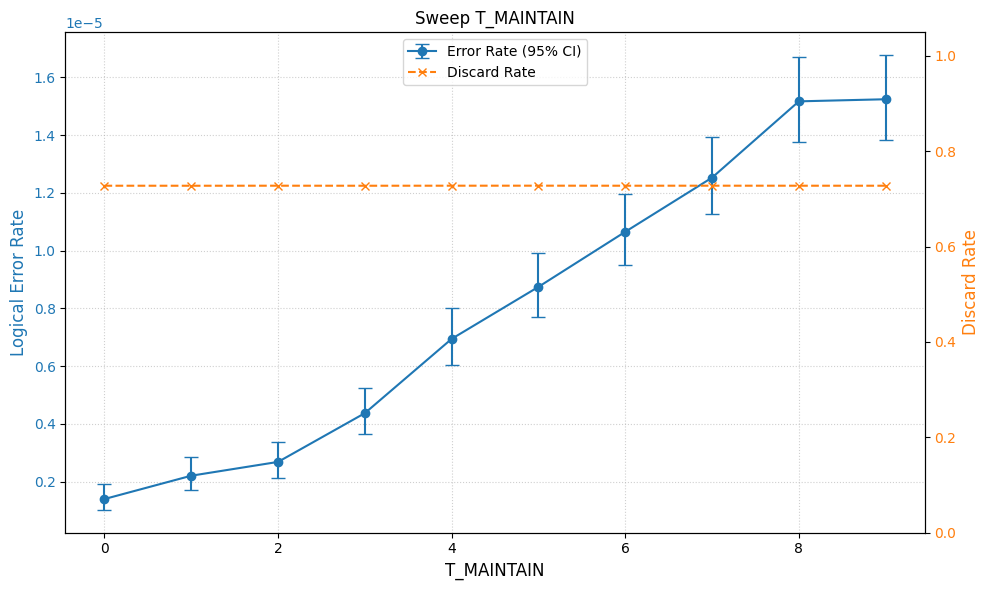

In [19]:
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
from collections import defaultdict

filename = '../data_collection/sinter_results_sweep_maintain.csv' # 你的文件名

# 1. 准备数据容器
# 使用 defaultdict，防止同一个 T_MAINTAIN 有多行数据
data_map = defaultdict(lambda: {'shots': 0, 'errors': 0, 'discards': 0})

with open(filename, 'r', newline='') as f:
    # skipinitialspace=True 可以忽略逗号后面的空格
    reader = csv.DictReader(f, skipinitialspace=True)
    
    # 【关键修正步骤】：强制去除表头里任何残留的空格
    if reader.fieldnames:
        reader.fieldnames = [name.strip() for name in reader.fieldnames]

    for row in reader:
        # 再次清洗 row 的内容，防止数据全是空字符串
        if not row.get('shots'): continue
        
        # 解析 Metadata 获取 X 轴变量 (T_MAINTAIN)
        try:
            meta = json.loads(row['json_metadata'])
            x_val = meta.get('T_MAINTAIN')
        except (json.JSONDecodeError, KeyError):
            continue 
        
        if x_val is None: continue 
        
        # 累加数据
        data_map[x_val]['shots'] += int(row['shots'])
        data_map[x_val]['errors'] += int(row['errors'])
        
        # 处理 discards
        d = row.get('discards')
        if d and d.strip():
            data_map[x_val]['discards'] += int(d)

# 2. 计算绘图所需的列表
sorted_xs = sorted(data_map.keys())

# Matplotlib 的 asymmetric error bar 需要两个数组：[lower_errors, upper_errors]
y_err_lows = []
y_err_highs = []
y_vals = []
y_disc_rates = []

# 定义 Wilson Score Interval 计算函数
def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

for x in sorted_xs:
    d = data_map[x]
    raw_shots = d['shots']       # 总尝试次数
    errors = d['errors']
    discards = d['discards']
    
    # 按你的修正：有效 shot = 总 shot - 丢弃
    # 逻辑错误率分母
    valid_shots = raw_shots - discards
    
    # --- 计算逻辑错误率 (带 Wilson Interval) ---
    if valid_shots > 0:
        p_hat, low_bound, high_bound = get_wilson_interval(errors, valid_shots)
        
        y_vals.append(p_hat)
        # Matplotlib 需要的是相对于点的“长度”，而不是绝对坐标
        y_err_lows.append(p_hat - low_bound)
        y_err_highs.append(high_bound - p_hat)
    else:
        y_vals.append(0)
        y_err_lows.append(0)
        y_err_highs.append(0)
    
    # --- 计算丢弃率 (按你的修正: discards / raw_shots) ---
    d_rate = discards / raw_shots if raw_shots > 0 else 0
    y_disc_rates.append(d_rate)

# 3. 开始绘图
fig, ax1 = plt.subplots(figsize=(10, 6))

color_err = 'tab:blue'
ax1.set_xlabel('T_MAINTAIN', fontsize=12)
ax1.set_ylabel('Logical Error Rate', color=color_err, fontsize=12)

# 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
asymmetric_err = [y_err_lows, y_err_highs]

line1 = ax1.errorbar(sorted_xs, y_vals, yerr=asymmetric_err, 
                     color=color_err, fmt='-o', capsize=5, label='Error Rate')

ax1.tick_params(axis='y', labelcolor=color_err)
ax1.grid(True, which='major', linestyle=':', alpha=0.6)

# 科学计数法
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# --- 右轴：Discard Rate ---
ax2 = ax1.twinx()
color_disc = 'tab:orange'
ax2.set_ylabel('Discard Rate', color=color_disc, fontsize=12)

line2, = ax2.plot(sorted_xs, y_disc_rates, color=color_disc, 
                  marker='x', linestyle='--', label='Discard Rate')

ax2.tick_params(axis='y', labelcolor=color_disc)
ax2.set_ylim(0, 1.05) 

# 图例
plt.legend([line1, line2], ['Error Rate (95% CI)', 'Discard Rate'], loc='upper center')

plt.title('Sweep T_MAINTAIN')
plt.tight_layout()
plt.show()


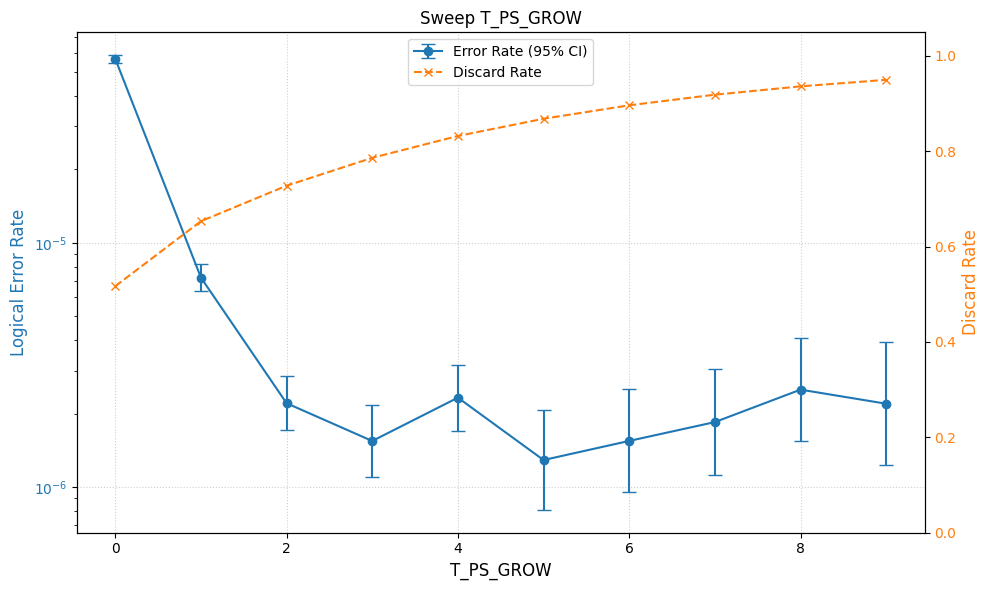

In [18]:
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
from collections import defaultdict

filename = '../data_collection/sinter_results_sweep_ps.csv' # 你的文件名

# 1. 准备数据容器
# 使用 defaultdict，防止同一个 T_MAINTAIN 有多行数据
data_map = defaultdict(lambda: {'shots': 0, 'errors': 0, 'discards': 0})

with open(filename, 'r', newline='') as f:
    # skipinitialspace=True 可以忽略逗号后面的空格
    reader = csv.DictReader(f, skipinitialspace=True)
    
    # 【关键修正步骤】：强制去除表头里任何残留的空格
    if reader.fieldnames:
        reader.fieldnames = [name.strip() for name in reader.fieldnames]

    for row in reader:
        # 再次清洗 row 的内容，防止数据全是空字符串
        if not row.get('shots'): continue
        
        # 解析 Metadata 获取 X 轴变量 (T_MAINTAIN)
        try:
            meta = json.loads(row['json_metadata'])
            x_val = meta.get('T_PS_GROW')
        except (json.JSONDecodeError, KeyError):
            continue 
        
        if x_val is None: continue 
        
        # 累加数据
        data_map[x_val]['shots'] += int(row['shots'])
        data_map[x_val]['errors'] += int(row['errors'])
        
        # 处理 discards
        d = row.get('discards')
        if d and d.strip():
            data_map[x_val]['discards'] += int(d)

# 2. 计算绘图所需的列表
sorted_xs = sorted(data_map.keys())

# Matplotlib 的 asymmetric error bar 需要两个数组：[lower_errors, upper_errors]
y_err_lows = []
y_err_highs = []
y_vals = []
y_disc_rates = []

# 定义 Wilson Score Interval 计算函数
def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

for x in sorted_xs:
    d = data_map[x]
    raw_shots = d['shots']       # 总尝试次数
    errors = d['errors']
    discards = d['discards']
    
    # 按你的修正：有效 shot = 总 shot - 丢弃
    # 逻辑错误率分母
    valid_shots = raw_shots - discards
    
    # --- 计算逻辑错误率 (带 Wilson Interval) ---
    if valid_shots > 0:
        p_hat, low_bound, high_bound = get_wilson_interval(errors, valid_shots)
        
        y_vals.append(p_hat)
        # Matplotlib 需要的是相对于点的“长度”，而不是绝对坐标
        y_err_lows.append(p_hat - low_bound)
        y_err_highs.append(high_bound - p_hat)
    else:
        y_vals.append(0)
        y_err_lows.append(0)
        y_err_highs.append(0)
    
    # --- 计算丢弃率 (按你的修正: discards / raw_shots) ---
    d_rate = discards / raw_shots if raw_shots > 0 else 0
    y_disc_rates.append(d_rate)

# 3. 开始绘图
fig, ax1 = plt.subplots(figsize=(10, 6))

color_err = 'tab:blue'
ax1.set_xlabel('T_PS_GROW', fontsize=12)
ax1.set_ylabel('Logical Error Rate', color=color_err, fontsize=12)
ax1.set_yscale('log')

# 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
asymmetric_err = [y_err_lows, y_err_highs]

line1 = ax1.errorbar(sorted_xs, y_vals, yerr=asymmetric_err, 
                     color=color_err, fmt='-o', capsize=5, label='Error Rate')

ax1.tick_params(axis='y', labelcolor=color_err)
ax1.grid(True, which='major', linestyle=':', alpha=0.6)

# 科学计数法
# ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# --- 右轴：Discard Rate ---
ax2 = ax1.twinx()
color_disc = 'tab:orange'
ax2.set_ylabel('Discard Rate', color=color_disc, fontsize=12)

line2, = ax2.plot(sorted_xs, y_disc_rates, color=color_disc, 
                  marker='x', linestyle='--', label='Discard Rate')

ax2.tick_params(axis='y', labelcolor=color_disc)
ax2.set_ylim(0, 1.05) 

# 图例
plt.legend([line1, line2], ['Error Rate (95% CI)', 'Discard Rate'], loc='upper center')

plt.title('Sweep T_PS_GROW')
plt.tight_layout()
plt.show()


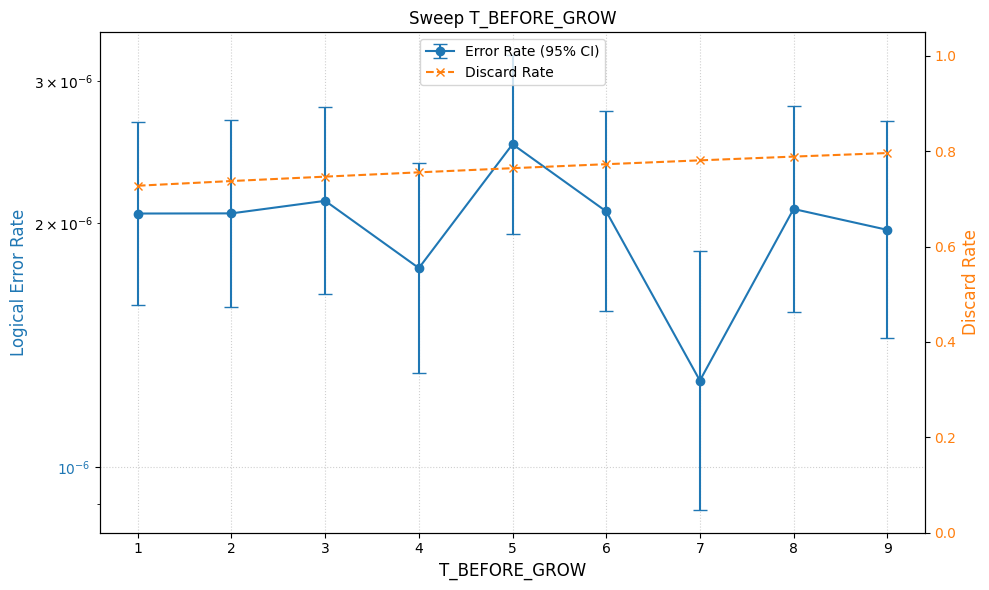

In [21]:
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
from collections import defaultdict

filename = '../data_collection/sinter_results_sweep_bfg.csv' # 你的文件名

# 1. 准备数据容器
# 使用 defaultdict，防止同一个 T_MAINTAIN 有多行数据
data_map = defaultdict(lambda: {'shots': 0, 'errors': 0, 'discards': 0})

with open(filename, 'r', newline='') as f:
    # skipinitialspace=True 可以忽略逗号后面的空格
    reader = csv.DictReader(f, skipinitialspace=True)
    
    # 【关键修正步骤】：强制去除表头里任何残留的空格
    if reader.fieldnames:
        reader.fieldnames = [name.strip() for name in reader.fieldnames]

    for row in reader:
        # 再次清洗 row 的内容，防止数据全是空字符串
        if not row.get('shots'): continue
        
        # 解析 Metadata 获取 X 轴变量 (T_MAINTAIN)
        try:
            meta = json.loads(row['json_metadata'])
            x_val = meta.get('T_BEFORE_GROW')
        except (json.JSONDecodeError, KeyError):
            continue 
        
        if x_val is None: continue 
        
        # 累加数据
        data_map[x_val]['shots'] += int(row['shots'])
        data_map[x_val]['errors'] += int(row['errors'])
        
        # 处理 discards
        d = row.get('discards')
        if d and d.strip():
            data_map[x_val]['discards'] += int(d)

# 2. 计算绘图所需的列表
sorted_xs = sorted(data_map.keys())

# Matplotlib 的 asymmetric error bar 需要两个数组：[lower_errors, upper_errors]
y_err_lows = []
y_err_highs = []
y_vals = []
y_disc_rates = []

# 定义 Wilson Score Interval 计算函数
def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

for x in sorted_xs:
    d = data_map[x]
    raw_shots = d['shots']       # 总尝试次数
    errors = d['errors']
    discards = d['discards']
    
    # 按你的修正：有效 shot = 总 shot - 丢弃
    # 逻辑错误率分母
    valid_shots = raw_shots - discards
    
    # --- 计算逻辑错误率 (带 Wilson Interval) ---
    if valid_shots > 0:
        p_hat, low_bound, high_bound = get_wilson_interval(errors, valid_shots)
        
        y_vals.append(p_hat)
        # Matplotlib 需要的是相对于点的“长度”，而不是绝对坐标
        y_err_lows.append(p_hat - low_bound)
        y_err_highs.append(high_bound - p_hat)
    else:
        y_vals.append(0)
        y_err_lows.append(0)
        y_err_highs.append(0)
    
    # --- 计算丢弃率 (按你的修正: discards / raw_shots) ---
    d_rate = discards / raw_shots if raw_shots > 0 else 0
    y_disc_rates.append(d_rate)

# 3. 开始绘图
fig, ax1 = plt.subplots(figsize=(10, 6))

color_err = 'tab:blue'
ax1.set_xlabel('T_BEFORE_GROW', fontsize=12)
ax1.set_ylabel('Logical Error Rate', color=color_err, fontsize=12)
ax1.set_yscale('log')

# 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
asymmetric_err = [y_err_lows, y_err_highs]

line1 = ax1.errorbar(sorted_xs, y_vals, yerr=asymmetric_err, 
                     color=color_err, fmt='-o', capsize=5, label='Error Rate')

ax1.tick_params(axis='y', labelcolor=color_err)
ax1.grid(True, which='major', linestyle=':', alpha=0.6)

# 科学计数法
# ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# --- 右轴：Discard Rate ---
ax2 = ax1.twinx()
color_disc = 'tab:orange'
ax2.set_ylabel('Discard Rate', color=color_disc, fontsize=12)

line2, = ax2.plot(sorted_xs, y_disc_rates, color=color_disc, 
                  marker='x', linestyle='--', label='Discard Rate')

ax2.tick_params(axis='y', labelcolor=color_disc)
ax2.set_ylim(0, 1.05) 

# 图例
plt.legend([line1, line2], ['Error Rate (95% CI)', 'Discard Rate'], loc='upper center')

plt.title('Sweep T_BEFORE_GROW')
plt.tight_layout()
plt.show()


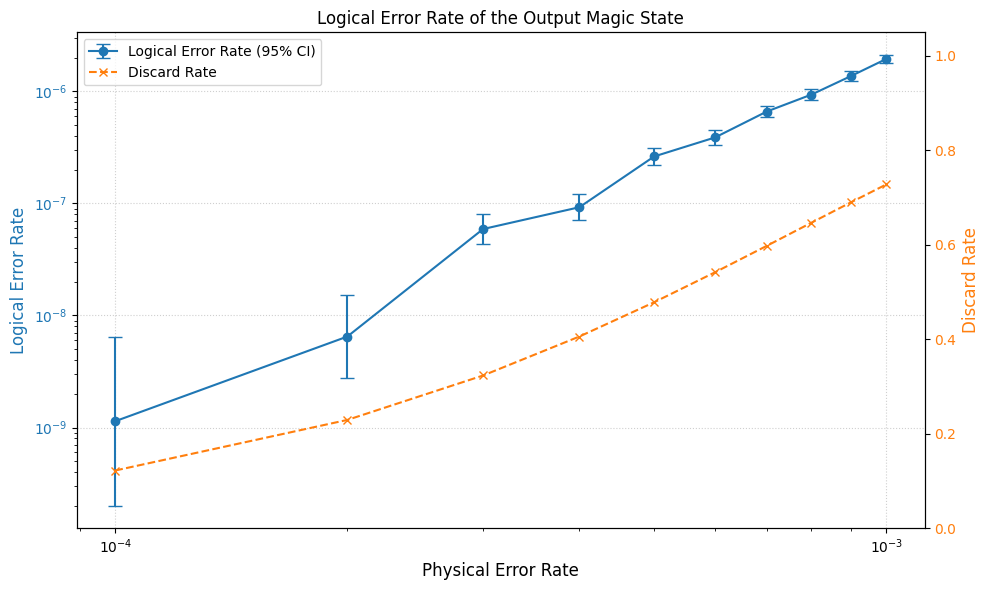

In [4]:
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
from collections import defaultdict

filename = '../data_collection/sinter_results_sweep_err.csv' # 你的文件名

# 1. 准备数据容器
# 使用 defaultdict，防止同一个 T_MAINTAIN 有多行数据
data_map = defaultdict(lambda: {'shots': 0, 'errors': 0, 'discards': 0})

with open(filename, 'r', newline='') as f:
    # skipinitialspace=True 可以忽略逗号后面的空格
    reader = csv.DictReader(f, skipinitialspace=True)
    
    # 【关键修正步骤】：强制去除表头里任何残留的空格
    if reader.fieldnames:
        reader.fieldnames = [name.strip() for name in reader.fieldnames]

    for row in reader:
        # 再次清洗 row 的内容，防止数据全是空字符串
        if not row.get('shots'): continue
        
        # 解析 Metadata 获取 X 轴变量 (T_MAINTAIN)
        try:
            meta = json.loads(row['json_metadata'])
            x_val = meta.get('p')
        except (json.JSONDecodeError, KeyError):
            continue 
        
        if x_val is None: continue 
        
        # 累加数据
        data_map[x_val]['shots'] += int(row['shots'])
        data_map[x_val]['errors'] += int(row['errors'])
        
        # 处理 discards
        d = row.get('discards')
        if d and d.strip():
            data_map[x_val]['discards'] += int(d)

# 2. 计算绘图所需的列表
sorted_xs = sorted(data_map.keys())

# Matplotlib 的 asymmetric error bar 需要两个数组：[lower_errors, upper_errors]
y_err_lows = []
y_err_highs = []
y_vals = []
y_disc_rates = []

# 定义 Wilson Score Interval 计算函数
def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

for x in sorted_xs:
    d = data_map[x]
    raw_shots = d['shots']       # 总尝试次数
    errors = d['errors']
    discards = d['discards']
    
    # 按你的修正：有效 shot = 总 shot - 丢弃
    # 逻辑错误率分母
    valid_shots = raw_shots - discards
    
    # --- 计算逻辑错误率 (带 Wilson Interval) ---
    if valid_shots > 0:
        p_hat, low_bound, high_bound = get_wilson_interval(errors, valid_shots)
        
        y_vals.append(p_hat)
        # Matplotlib 需要的是相对于点的“长度”，而不是绝对坐标
        y_err_lows.append(p_hat - low_bound)
        y_err_highs.append(high_bound - p_hat)
    else:
        y_vals.append(0)
        y_err_lows.append(0)
        y_err_highs.append(0)
    
    # --- 计算丢弃率 (按你的修正: discards / raw_shots) ---
    d_rate = discards / raw_shots if raw_shots > 0 else 0
    y_disc_rates.append(d_rate)

# 3. 开始绘图
fig, ax1 = plt.subplots(figsize=(10, 6))

color_err = 'tab:blue'
ax1.set_xlabel('Physical Error Rate', fontsize=12)
ax1.set_ylabel('Logical Error Rate', color=color_err, fontsize=12)
ax1.set_yscale('log')
ax1.set_xscale('log')

# 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
asymmetric_err = [y_err_lows, y_err_highs]

line1 = ax1.errorbar(sorted_xs, y_vals, yerr=asymmetric_err, 
                     color=color_err, fmt='-o', capsize=5, label='Error Rate')

ax1.tick_params(axis='y', labelcolor=color_err)
ax1.grid(True, which='major', linestyle=':', alpha=0.6)

# 科学计数法
# ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

# --- 右轴：Discard Rate ---
ax2 = ax1.twinx()
color_disc = 'tab:orange'
ax2.set_ylabel('Discard Rate', color=color_disc, fontsize=12)

line2, = ax2.plot(sorted_xs, y_disc_rates, color=color_disc, 
                  marker='x', linestyle='--', label='Discard Rate')

ax2.tick_params(axis='y', labelcolor=color_disc)
ax2.set_ylim(0, 1.05) 

# 图例
plt.legend([line1, line2], ['Logical Error Rate (95% CI)', 'Discard Rate'], loc='upper left')

plt.title('Logical Error Rate of the Output Magic State')
plt.tight_layout()
plt.show()


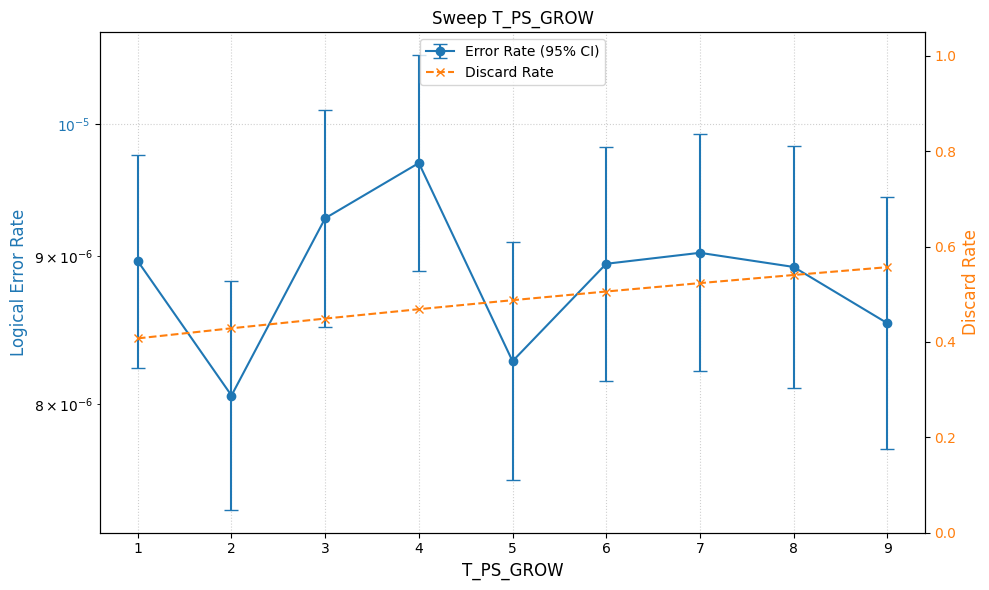

In [8]:
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
from collections import defaultdict

filename = '../no_grow/sinter_results_sweep_ps.csv' # 你的文件名

# 1. 准备数据容器
# 使用 defaultdict，防止同一个 T_MAINTAIN 有多行数据
data_map = defaultdict(lambda: {'shots': 0, 'errors': 0, 'discards': 0})

with open(filename, 'r', newline='') as f:
    # skipinitialspace=True 可以忽略逗号后面的空格
    reader = csv.DictReader(f, skipinitialspace=True)
    
    # 【关键修正步骤】：强制去除表头里任何残留的空格
    if reader.fieldnames:
        reader.fieldnames = [name.strip() for name in reader.fieldnames]

    for row in reader:
        # 再次清洗 row 的内容，防止数据全是空字符串
        if not row.get('shots'): continue
        
        # 解析 Metadata 获取 X 轴变量 (T_MAINTAIN)
        try:
            meta = json.loads(row['json_metadata'])
            x_val = meta.get('T_BEFORE_GROW')
        except (json.JSONDecodeError, KeyError):
            continue 
        
        if x_val is None: continue 
        
        # 累加数据
        data_map[x_val]['shots'] += int(row['shots'])
        data_map[x_val]['errors'] += int(row['errors'])
        
        # 处理 discards
        d = row.get('discards')
        if d and d.strip():
            data_map[x_val]['discards'] += int(d)

# 2. 计算绘图所需的列表
sorted_xs = sorted(data_map.keys())

# Matplotlib 的 asymmetric error bar 需要两个数组：[lower_errors, upper_errors]
y_err_lows = []
y_err_highs = []
y_vals = []
y_disc_rates = []

# 定义 Wilson Score Interval 计算函数
def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

for x in sorted_xs:
    d = data_map[x]
    raw_shots = d['shots']       # 总尝试次数
    errors = d['errors']
    discards = d['discards']
    
    # 按你的修正：有效 shot = 总 shot - 丢弃
    # 逻辑错误率分母
    valid_shots = raw_shots - discards
    
    # --- 计算逻辑错误率 (带 Wilson Interval) ---
    if valid_shots > 0:
        p_hat, low_bound, high_bound = get_wilson_interval(errors, valid_shots)
        
        y_vals.append(p_hat)
        # Matplotlib 需要的是相对于点的“长度”，而不是绝对坐标
        y_err_lows.append(p_hat - low_bound)
        y_err_highs.append(high_bound - p_hat)
    else:
        y_vals.append(0)
        y_err_lows.append(0)
        y_err_highs.append(0)
    
    # --- 计算丢弃率 (按你的修正: discards / raw_shots) ---
    d_rate = discards / raw_shots if raw_shots > 0 else 0
    y_disc_rates.append(d_rate)

# 3. 开始绘图
fig, ax1 = plt.subplots(figsize=(10, 6))

color_err = 'tab:blue'
ax1.set_xlabel('T_PS_GROW', fontsize=12)
ax1.set_ylabel('Logical Error Rate', color=color_err, fontsize=12)
ax1.set_yscale('log')

# 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
asymmetric_err = [y_err_lows, y_err_highs]

line1 = ax1.errorbar(sorted_xs, y_vals, yerr=asymmetric_err, 
                     color=color_err, fmt='-o', capsize=5, label='Error Rate')

ax1.tick_params(axis='y', labelcolor=color_err)
ax1.grid(True, which='major', linestyle=':', alpha=0.6)

# 科学计数法
# ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# --- 右轴：Discard Rate ---
ax2 = ax1.twinx()
color_disc = 'tab:orange'
ax2.set_ylabel('Discard Rate', color=color_disc, fontsize=12)

line2, = ax2.plot(sorted_xs, y_disc_rates, color=color_disc, 
                  marker='x', linestyle='--', label='Discard Rate')

ax2.tick_params(axis='y', labelcolor=color_disc)
ax2.set_ylim(0, 1.05) 

# 图例
plt.legend([line1, line2], ['Error Rate (95% CI)', 'Discard Rate'], loc='upper center')

plt.title('Sweep T_PS_GROW')
plt.tight_layout()
plt.show()

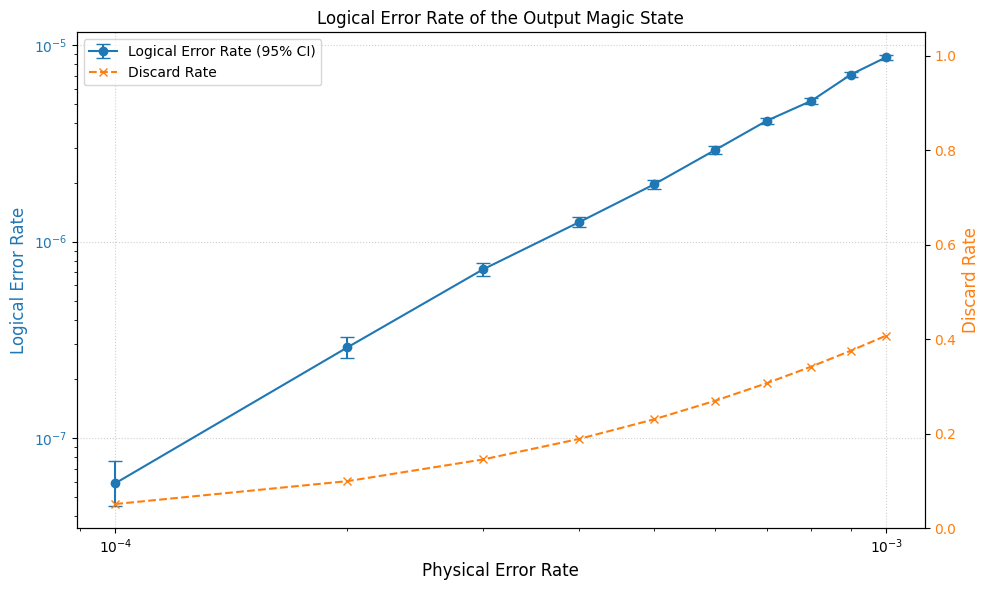

In [ ]:
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
from collections import defaultdict

filename = '../no_grow/sinter_results_sweep_err.csv' # 你的文件名

# 1. 准备数据容器
# 使用 defaultdict，防止同一个 T_MAINTAIN 有多行数据
data_map = defaultdict(lambda: {'shots': 0, 'errors': 0, 'discards': 0})

with open(filename, 'r', newline='') as f:
    # skipinitialspace=True 可以忽略逗号后面的空格
    reader = csv.DictReader(f, skipinitialspace=True)
    
    # 【关键修正步骤】：强制去除表头里任何残留的空格
    if reader.fieldnames:
        reader.fieldnames = [name.strip() for name in reader.fieldnames]

    for row in reader:
        # 再次清洗 row 的内容，防止数据全是空字符串
        if not row.get('shots'): continue
        
        # 解析 Metadata 获取 X 轴变量 (T_MAINTAIN)
        try:
            meta = json.loads(row['json_metadata'])
            x_val = meta.get('p')
        except (json.JSONDecodeError, KeyError):
            continue 
        
        if x_val is None: continue 
        
        # 累加数据
        data_map[x_val]['shots'] += int(row['shots'])
        data_map[x_val]['errors'] += int(row['errors'])
        
        # 处理 discards
        d = row.get('discards')
        if d and d.strip():
            data_map[x_val]['discards'] += int(d)

# 2. 计算绘图所需的列表
sorted_xs = sorted(data_map.keys())

# Matplotlib 的 asymmetric error bar 需要两个数组：[lower_errors, upper_errors]
y_err_lows = []
y_err_highs = []
y_vals = []
y_disc_rates = []

# 定义 Wilson Score Interval 计算函数
def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

for x in sorted_xs:
    d = data_map[x]
    raw_shots = d['shots']       # 总尝试次数
    errors = d['errors']
    discards = d['discards']
    
    # 按你的修正：有效 shot = 总 shot - 丢弃
    # 逻辑错误率分母
    valid_shots = raw_shots - discards
    
    # --- 计算逻辑错误率 (带 Wilson Interval) ---
    if valid_shots > 0:
        p_hat, low_bound, high_bound = get_wilson_interval(errors, valid_shots)
        
        y_vals.append(p_hat)
        # Matplotlib 需要的是相对于点的“长度”，而不是绝对坐标
        y_err_lows.append(p_hat - low_bound)
        y_err_highs.append(high_bound - p_hat)
    else:
        y_vals.append(0)
        y_err_lows.append(0)
        y_err_highs.append(0)
    
    # --- 计算丢弃率 (按你的修正: discards / raw_shots) ---
    d_rate = discards / raw_shots if raw_shots > 0 else 0
    y_disc_rates.append(d_rate)

# 3. 开始绘图
fig, ax1 = plt.subplots(figsize=(10, 6))

color_err = 'tab:blue'
ax1.set_xlabel('Physical Error Rate', fontsize=12)
ax1.set_ylabel('Logical Error Rate', color=color_err, fontsize=12)
ax1.set_yscale('log')
ax1.set_xscale('log')

# 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
asymmetric_err = [y_err_lows, y_err_highs]

line1 = ax1.errorbar(sorted_xs, y_vals, yerr=asymmetric_err, 
                     color=color_err, fmt='-o', capsize=5, label='Error Rate')

ax1.tick_params(axis='y', labelcolor=color_err)
ax1.grid(True, which='major', linestyle=':', alpha=0.6)

# 科学计数法
# ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

# --- 右轴：Discard Rate ---
ax2 = ax1.twinx()
color_disc = 'tab:orange'
ax2.set_ylabel('Discard Rate', color=color_disc, fontsize=12)

line2, = ax2.plot(sorted_xs, y_disc_rates, color=color_disc, 
                  marker='x', linestyle='--', label='Discard Rate')

ax2.tick_params(axis='y', labelcolor=color_disc)
ax2.set_ylim(0, 1.05) 

# 图例
plt.legend([line1, line2], ['Logical Error Rate (95% CI)', 'Discard Rate'], loc='upper left')

plt.title('Logical Error Rate of the Output Magic State')
plt.tight_layout()
plt.show()

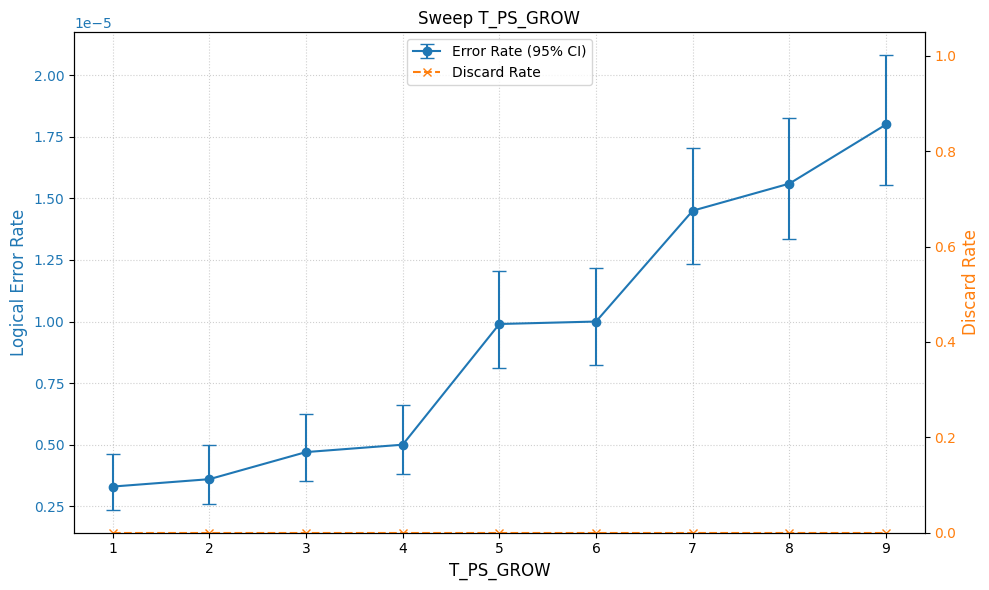

In [30]:
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
from collections import defaultdict

filename = '../online/sinter_results_sweep_time_bposd_1e-06.csv' # 你的文件名

# 1. 准备数据容器
# 使用 defaultdict，防止同一个 T_MAINTAIN 有多行数据
data_map = defaultdict(lambda: {'shots': 0, 'errors': 0, 'discards': 0})

with open(filename, 'r', newline='') as f:
    # skipinitialspace=True 可以忽略逗号后面的空格
    reader = csv.DictReader(f, skipinitialspace=True)
    
    # 【关键修正步骤】：强制去除表头里任何残留的空格
    if reader.fieldnames:
        reader.fieldnames = [name.strip() for name in reader.fieldnames]

    for row in reader:
        # 再次清洗 row 的内容，防止数据全是空字符串
        if not row.get('shots'): continue
        
        # 解析 Metadata 获取 X 轴变量 (T_MAINTAIN)
        try:
            meta = json.loads(row['json_metadata'])
            x_val = meta.get('time')
        except (json.JSONDecodeError, KeyError):
            continue 
        
        if x_val is None: continue 
        
        # 累加数据
        data_map[x_val]['shots'] += int(row['shots'])
        data_map[x_val]['errors'] += int(row['errors'])
        
        # 处理 discards
        d = row.get('discards')
        if d and d.strip():
            data_map[x_val]['discards'] += int(d)

# 2. 计算绘图所需的列表
sorted_xs = sorted(data_map.keys())

# Matplotlib 的 asymmetric error bar 需要两个数组：[lower_errors, upper_errors]
y_err_lows = []
y_err_highs = []
y_vals = []
y_disc_rates = []

# 定义 Wilson Score Interval 计算函数
def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

for x in sorted_xs:
    d = data_map[x]
    raw_shots = d['shots']       # 总尝试次数
    errors = d['errors']
    discards = d['discards']
    
    # 按你的修正：有效 shot = 总 shot - 丢弃
    # 逻辑错误率分母
    valid_shots = raw_shots - discards
    
    # --- 计算逻辑错误率 (带 Wilson Interval) ---
    if valid_shots > 0:
        p_hat, low_bound, high_bound = get_wilson_interval(errors, valid_shots)
        
        y_vals.append(p_hat)
        # Matplotlib 需要的是相对于点的“长度”，而不是绝对坐标
        y_err_lows.append(p_hat - low_bound)
        y_err_highs.append(high_bound - p_hat)
    else:
        y_vals.append(0)
        y_err_lows.append(0)
        y_err_highs.append(0)
    
    # --- 计算丢弃率 (按你的修正: discards / raw_shots) ---
    d_rate = discards / raw_shots if raw_shots > 0 else 0
    y_disc_rates.append(d_rate)

# 3. 开始绘图
fig, ax1 = plt.subplots(figsize=(10, 6))

color_err = 'tab:blue'
ax1.set_xlabel('T_PS_GROW', fontsize=12)
ax1.set_ylabel('Logical Error Rate', color=color_err, fontsize=12)
# ax1.set_yscale('log')

# 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
asymmetric_err = [y_err_lows, y_err_highs]

line1 = ax1.errorbar(sorted_xs, y_vals, yerr=asymmetric_err, 
                     color=color_err, fmt='-o', capsize=5, label='Error Rate')

ax1.tick_params(axis='y', labelcolor=color_err)
ax1.grid(True, which='major', linestyle=':', alpha=0.6)

# 科学计数法
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# --- 右轴：Discard Rate ---
ax2 = ax1.twinx()
color_disc = 'tab:orange'
ax2.set_ylabel('Discard Rate', color=color_disc, fontsize=12)

line2, = ax2.plot(sorted_xs, y_disc_rates, color=color_disc, 
                  marker='x', linestyle='--', label='Discard Rate')

ax2.tick_params(axis='y', labelcolor=color_disc)
ax2.set_ylim(0, 1.05) 

# 图例
plt.legend([line1, line2], ['Error Rate (95% CI)', 'Discard Rate'], loc='upper center')

plt.title('Sweep T_PS_GROW')
plt.tight_layout()
plt.show()

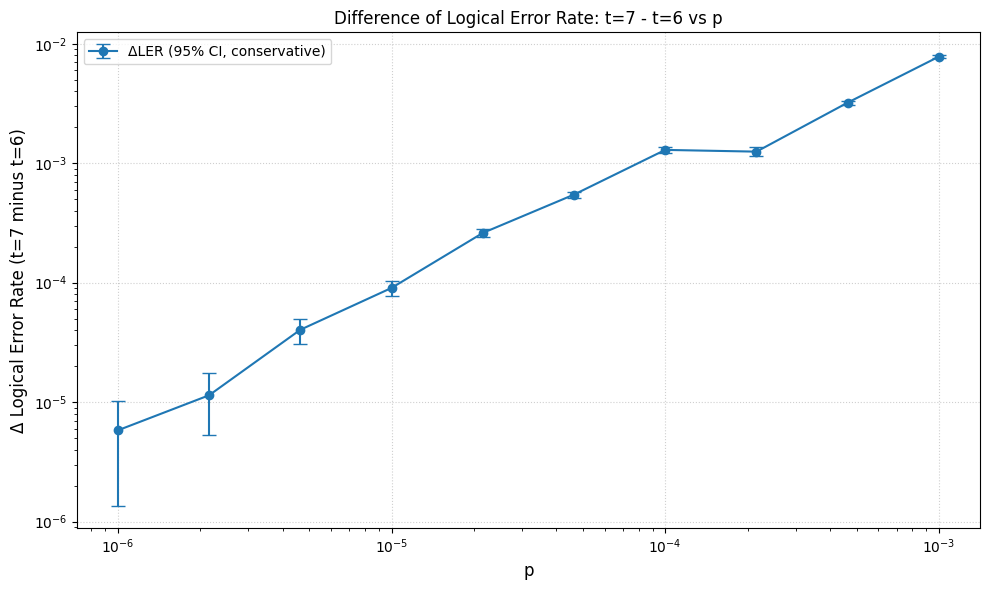

In [83]:
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
from collections import defaultdict

filename = '../online/sinter_results_sweep_time_bposd_err.csv'

# data_map[p][t] = {'shots':..., 'errors':..., 'discards':...}
data_map = defaultdict(lambda: defaultdict(lambda: {'shots': 0, 'errors': 0, 'discards': 0}))

with open(filename, 'r', newline='') as f:
    reader = csv.DictReader(f, skipinitialspace=True)
    if reader.fieldnames:
        reader.fieldnames = [name.strip() for name in reader.fieldnames]

    for row in reader:
        if not row.get('shots'):
            continue

        try:
            meta = json.loads(row['json_metadata'])
            p_val = meta.get('p', None)
            t_val = meta.get('t', None)
        except (json.JSONDecodeError, KeyError):
            continue

        if p_val is None or t_val is None:
            continue

        # 只关心 t=6 和 t=7（你也可以删掉这句，改成通用）
        if int(t_val) not in (6, 7):
            continue

        p_val = float(p_val)
        t_val = int(t_val)

        data_map[p_val][t_val]['shots'] += int(row['shots'])
        data_map[p_val][t_val]['errors'] += int(row['errors'])

        d = row.get('discards')
        if d and d.strip():
            data_map[p_val][t_val]['discards'] += int(d)

# Wilson Score Interval
def get_wilson_interval(k, n, z=1.96):
    if n == 0:
        return 0.0, 0.0, 0.0
    p_hat = k / n
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    lower = max(0.0, center_adjusted - spread)
    upper = min(1.0, center_adjusted + spread)
    return p_hat, lower, upper

def rate_and_ci(d):
    raw_shots = d['shots']
    discards = d['discards']
    errors = d['errors']
    valid_shots = raw_shots - discards
    return get_wilson_interval(errors, valid_shots)

# 计算差值：delta = rate(t=7) - rate(t=6)
sorted_ps = sorted(data_map.keys())

xs = []
delta_vals = []
delta_err_lows = []
delta_err_highs = []

for p in sorted_ps:
    if 6 not in data_map[p] or 7 not in data_map[p]:
        continue

    r6, l6, u6 = rate_and_ci(data_map[p][6])
    r7, l7, u7 = rate_and_ci(data_map[p][7])

    delta = r7 - r6

    # 用各自 Wilson 区间给差值构造一个“保守”的区间：
    # delta_low  = (t7 的下界) - (t6 的上界)
    # delta_high = (t7 的上界) - (t6 的下界)
    delta_low = l7 - u6
    delta_high = u7 - l6

    xs.append(p)
    delta_vals.append(delta)
    delta_err_lows.append(delta - delta_low)
    delta_err_highs.append(delta_high - delta)

# 画图
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('p', fontsize=12)
ax.set_ylabel('Δ Logical Error Rate (t=7 minus t=6)', fontsize=12)

ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='major', linestyle=':', alpha=0.6)
ax.axhline(0.0, color='gray', linewidth=1)

asymmetric_err = [delta_err_lows, delta_err_highs]
ax.errorbar(xs, delta_vals, yerr=asymmetric_err, fmt='-o', capsize=5, label='ΔLER (95% CI, conservative)')

ax.legend(loc='best')
plt.title('Difference of Logical Error Rate: t=7 - t=6 vs p')
plt.tight_layout()
plt.show()


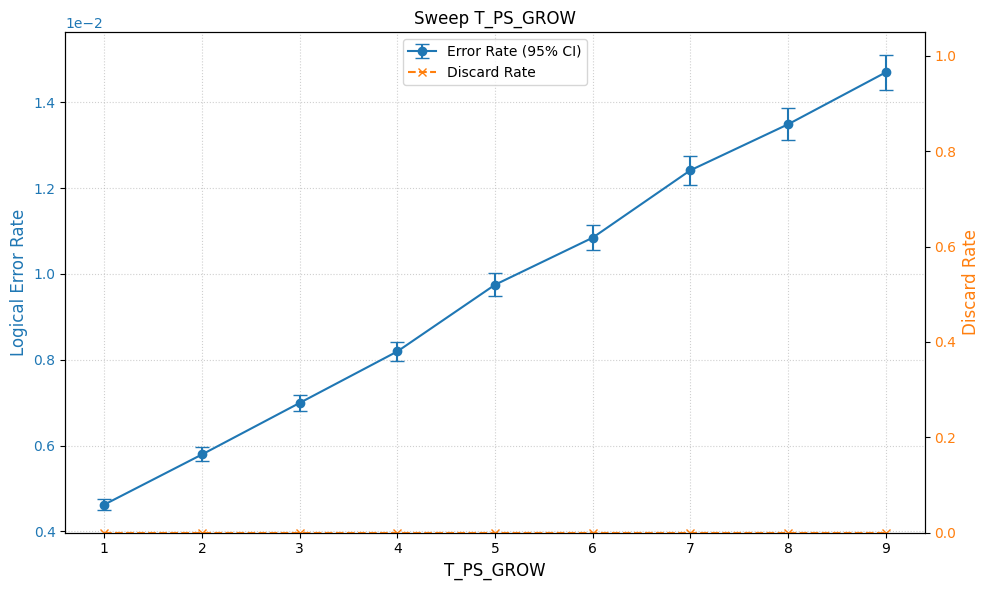

In [6]:
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
from collections import defaultdict

filename = '../online/sinter_results_sweep_time_sc.csv' # 你的文件名

# 1. 准备数据容器
# 使用 defaultdict，防止同一个 T_MAINTAIN 有多行数据
data_map = defaultdict(lambda: {'shots': 0, 'errors': 0, 'discards': 0})

with open(filename, 'r', newline='') as f:
    # skipinitialspace=True 可以忽略逗号后面的空格
    reader = csv.DictReader(f, skipinitialspace=True)
    
    # 【关键修正步骤】：强制去除表头里任何残留的空格
    if reader.fieldnames:
        reader.fieldnames = [name.strip() for name in reader.fieldnames]

    for row in reader:
        # 再次清洗 row 的内容，防止数据全是空字符串
        if not row.get('shots'): continue
        
        # 解析 Metadata 获取 X 轴变量 (T_MAINTAIN)
        try:
            meta = json.loads(row['json_metadata'])
            x_val = meta.get('time')
        except (json.JSONDecodeError, KeyError):
            continue 
        
        if x_val is None: continue 
        
        # 累加数据
        data_map[x_val]['shots'] += int(row['shots'])
        data_map[x_val]['errors'] += int(row['errors'])
        
        # 处理 discards
        d = row.get('discards')
        if d and d.strip():
            data_map[x_val]['discards'] += int(d)

# 2. 计算绘图所需的列表
sorted_xs = sorted(data_map.keys())

# Matplotlib 的 asymmetric error bar 需要两个数组：[lower_errors, upper_errors]
y_err_lows = []
y_err_highs = []
y_vals = []
y_disc_rates = []

# 定义 Wilson Score Interval 计算函数
def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

for x in sorted_xs:
    d = data_map[x]
    raw_shots = d['shots']       # 总尝试次数
    errors = d['errors']
    discards = d['discards']
    
    # 按你的修正：有效 shot = 总 shot - 丢弃
    # 逻辑错误率分母
    valid_shots = raw_shots - discards
    
    # --- 计算逻辑错误率 (带 Wilson Interval) ---
    if valid_shots > 0:
        p_hat, low_bound, high_bound = get_wilson_interval(errors, valid_shots)
        
        y_vals.append(p_hat)
        # Matplotlib 需要的是相对于点的“长度”，而不是绝对坐标
        y_err_lows.append(p_hat - low_bound)
        y_err_highs.append(high_bound - p_hat)
    else:
        y_vals.append(0)
        y_err_lows.append(0)
        y_err_highs.append(0)
    
    # --- 计算丢弃率 (按你的修正: discards / raw_shots) ---
    d_rate = discards / raw_shots if raw_shots > 0 else 0
    y_disc_rates.append(d_rate)

# 3. 开始绘图
fig, ax1 = plt.subplots(figsize=(10, 6))

color_err = 'tab:blue'
ax1.set_xlabel('T_PS_GROW', fontsize=12)
ax1.set_ylabel('Logical Error Rate', color=color_err, fontsize=12)
# ax1.set_yscale('log')

# 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
asymmetric_err = [y_err_lows, y_err_highs]

line1 = ax1.errorbar(sorted_xs, y_vals, yerr=asymmetric_err, 
                     color=color_err, fmt='-o', capsize=5, label='Error Rate')

ax1.tick_params(axis='y', labelcolor=color_err)
ax1.grid(True, which='major', linestyle=':', alpha=0.6)

# 科学计数法
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# --- 右轴：Discard Rate ---
ax2 = ax1.twinx()
color_disc = 'tab:orange'
ax2.set_ylabel('Discard Rate', color=color_disc, fontsize=12)

line2, = ax2.plot(sorted_xs, y_disc_rates, color=color_disc, 
                  marker='x', linestyle='--', label='Discard Rate')

ax2.tick_params(axis='y', labelcolor=color_disc)
ax2.set_ylim(0, 1.05) 

# 图例
plt.legend([line1, line2], ['Error Rate (95% CI)', 'Discard Rate'], loc='upper center')

plt.title('Sweep T_PS_GROW')
plt.tight_layout()
plt.show()

In [9]:
# 定义 Wilson Score Interval 计算函数
def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

In [ ]:
# error rate after gate teleportation
log_err_phy = list(np.linspace(-2.5, -3.0, 6))
err_log_cnt = [593, 595, 596, 598, 597, 598]
total_cnt = [11010, 17500, 26600, 40500, 62800, 95400]

err_log = []
y_err_lows = []
y_err_highs = []

for i in range(len(err_log_cnt)):
    p_hat, low_bound, high_bound = get_wilson_interval(err_log_cnt[i], total_cnt[i])
    err_log.append(p_hat)
    y_err_lows.append(p_hat - low_bound)
    y_err_highs.append(high_bound - p_hat)

print(err_log)
print(y_err_lows)
print(y_err_highs)
print([np.log10(x) for x in err_log])

[0.05386012715712988, 0.034, 0.022406015037593985, 0.014765432098765432, 0.009506369426751593, 0.006268343815513627]
[0.004063233323913201, 0.002584507188688502, 0.0017108375636003328, 0.0011295083981727877, 0.0007295104637132562, 0.00048133630964831194]
[0.004374458234849485, 0.0027890549263691264, 0.0018487668957785502, 0.0012215528582740463, 0.0007895157208187443, 0.0005210982206696893]
[-1.2687326256074891, -1.4685210829577449, -1.6496353768908305, -1.8307538392262577, -2.021985312607827, -2.2028471907156844]


In [ ]:
# error rate after gate teleportation (matching)
log_err_phy= list(np.linspace(-2.5, -3.0, 6))
err_log_cnt_matching = [142016, 113554, 89808, 71910, 57095, 45259]
total_cnt_matching = [1000000, 1000000, 1000000, 1000000, 1000000, 1000000]
err_log_matching = []
y_err_lows_matching = []
y_err_highs_matching = []

for i in range(len(err_log_cnt_matching)):
    p_hat, low_bound, high_bound = get_wilson_interval(err_log_cnt_matching[i], total_cnt_matching[i])
    err_log_matching.append(p_hat)
    y_err_lows_matching.append(p_hat - low_bound)
    y_err_highs_matching.append(high_bound - p_hat)

print(err_log_matching)
print(y_err_lows_matching)
print(y_err_highs_matching)
print([np.log10(x) for x in err_log_matching])

[0.142016, 0.113554, 0.089808, 0.07191, 0.057095, 0.045259]
[0.0006827952783029223, 0.0006203628530790095, 0.000558802079305365, 0.0005047012637176135, 0.000453067995123492, 0.00040568447044070366]
[0.0006855457304055512, 0.0006233319835799722, 0.0005619536543726433, 0.0005079903521702372, 0.00045647090974684085, 0.0004091783230699142]
[-0.8476627237841045, -0.9447975629208577, -1.046684975124403, -1.1432107112466838, -1.2434019227084128, -1.344295046034842]


In [125]:
# error rate before gate teleportation
log_err_phy_before = list(np.linspace(-2.5, -3.0, 6))
# err_log_cnt_before = [49100, 50079, 50682, 50171, 50325, 50002][::-1]
# total_cnt_before = [100000000, 65517254, 42264328, 26646845, 17059200, 10759697][::-1]
err_log_cnt_before = [5254, 3527, 2335, 1584, 1019, 715]
total_cnt_before = [1000000, 1000000, 1000000, 1000000, 1000000, 1000000]

err_log_before = []
y_err_lows_before = []  
y_err_highs_before = []

for i in range(len(err_log_cnt_before)):
    p_hat, low_bound, high_bound = get_wilson_interval(err_log_cnt_before[i], total_cnt_before[i])
    err_log_before.append(p_hat)
    y_err_lows_before.append(p_hat - low_bound)
    y_err_highs_before.append(high_bound - p_hat)

print(err_log_before)
print(y_err_lows_before)
print(y_err_highs_before)

# difference 
delta_err_log = []
delta_err_lows = []
delta_err_highs = []

for i in range(len(err_log_before)):
    delta = err_log[i] - err_log_before[i]
    delta_err_log.append(delta)
    
    # 差值的区间
    delta_low = (err_log[i] - y_err_lows[i]) - (err_log_before[i] + y_err_highs_before[i])
    delta_high = (err_log[i] + y_err_highs[i]) - (err_log_before[i] - y_err_lows_before[i])
    
    delta_err_lows.append(delta - delta_low)
    delta_err_highs.append(delta_high - delta)

print(delta_err_log)
print(delta_err_lows)
print(delta_err_highs)

[0.005254, 0.003527, 0.002335, 0.001584, 0.001019, 0.000715]
[0.00013980773971164484, 0.00011430428984265809, 9.270747476545745e-05, 7.605386545273484e-05, 6.064717577846637e-05, 5.050760082998254e-05]
[0.00014360895757608606, 0.00011811877654252555, 9.653111980454212e-05, 7.988328055285351e-05, 6.44809318699085e-05, 5.434369260525233e-05]
[0.04860612715712988, 0.030473000000000004, 0.020071015037593985, 0.013181432098765431, 0.008487369426751594, 0.005553343815513627]
[0.004206842281489286, 0.0027026259652310307, 0.0018073686834048745, 0.0012093916787256406, 0.000793991395583166, 0.0005356800022535638]
[0.00451426597456113, 0.0029033592162117823, 0.0019414743705440073, 0.0012976067237267814, 0.0008501628965972095, 0.0005716058214996723]


In [162]:
# difference 
delta_err_log_matching = []
delta_err_lows_matching = []
delta_err_highs_matching = []

for i in range(len(err_log_before)):
    delta = err_log_matching[i] - err_log_before[i]
    delta_err_log_matching.append(delta)
    
    # 差值的区间
    delta_low = (err_log_matching[i] - y_err_lows_matching[i]) - (err_log_before[i] + y_err_highs_before[i])
    delta_high = (err_log_matching[i] + y_err_highs_matching[i]) - (err_log_before[i] - y_err_lows_before[i])

    delta_err_lows_matching.append(delta - delta_low)
    delta_err_highs_matching.append(delta_high - delta)

print(delta_err_log_matching)
print(delta_err_lows_matching)
print(delta_err_highs_matching)

[0.136762, 0.110027, 0.087473, 0.070326, 0.056076, 0.044544]
[0.0008264042358789858, 0.0007384816296215346, 0.0006553331991099032, 0.0005845845442704611, 0.0005175489269933983, 0.00046002816304595295]
[0.0008253534701171961, 0.0007376362734226316, 0.0006546611291381038, 0.000584044217622981, 0.000517118085525306, 0.00045968592389989543]


In [187]:
# 7 rounds of surface code
log_err_phy= list(np.linspace(-2.5, -3.0, 6))
err_log_cnt_sc = [15246, 10469, 7311, 4934, 3412, 2338]
total_cnt_sc = [1000000, 1000000, 1000000, 1000000, 1000000, 1000000]
err_log_sc = []
y_err_lows_sc = []
y_err_highs_sc = []

for i in range(len(err_log_cnt_sc)):
    p_hat, low_bound, high_bound = get_wilson_interval(err_log_cnt_sc[i], total_cnt_sc[i])
    err_log_sc.append(p_hat)
    y_err_lows_sc.append(p_hat - low_bound)
    y_err_highs_sc.append(high_bound - p_hat)

print(err_log_sc)
print(y_err_lows_sc)
print(y_err_highs_sc)
print([np.log10(x) for x in err_log_sc])

[0.015246, 0.010469, 0.007311, 0.004934, 0.003412, 0.002338]
[0.00023830300352829445, 0.00019761893588683514, 0.00016509255167025498, 0.00013544617832716814, 0.00011240069319976096, 9.276808272707868e-05]
[0.00024202745115325247, 0.0002013800860171961, 0.00016887796525300904, 0.00013924985480616436, 0.00011621606346423445, 9.659170471665226e-05]
[-1.816844084565987, -1.980094800195386, -2.136023216095613, -2.3068008548462826, -2.4669909775045147, -2.6311554931741785]


In [188]:
# difference 
delta_err_log_sc = []
delta_err_lows_sc = []
delta_err_highs_sc = []

for i in range(len(err_log_before)):
    delta = err_log_sc[i] - err_log_before[i]
    delta_err_log_sc.append(delta)
    
    # 差值的区间
    delta_low = (err_log_sc[i] - y_err_lows_sc[i]) - (err_log_before[i] + y_err_highs_before[i])
    delta_high = (err_log_sc[i] + y_err_highs_sc[i]) - (err_log_before[i] - y_err_lows_before[i])

    delta_err_lows_sc.append(delta - delta_low)
    delta_err_highs_sc.append(delta_high - delta)

print(delta_err_log_sc)
print(delta_err_lows_sc)
print(delta_err_highs_sc)

[0.009992, 0.0069419999999999985, 0.0049759999999999995, 0.00335, 0.002393, 0.0016229999999999999]
[0.0003819119611043805, 0.00031573771242936026, 0.00026162367147479666, 0.00021532945888002144, 0.00017688162506966946, 0.000147111775332331]
[0.0003818351908648973, 0.00031568437585985463, 0.0002615854400184669, 0.00021530372025889899, 0.00017686323924270093, 0.0001470993055466348]


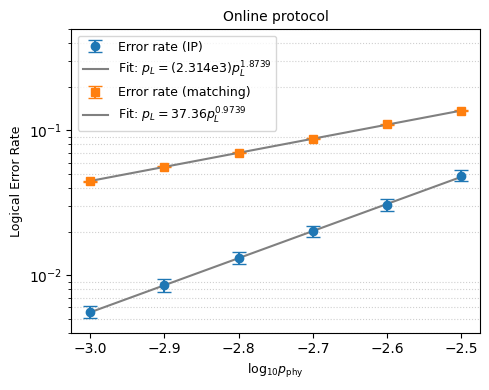

In [197]:
# 3. 开始绘图
fig, ax1 = plt.subplots(figsize=(5, 4))

title_font_size = 10
label_font_size = 9

# color_err = 'tab:blue'
ax1.set_xlabel(r'log$_{10}p_{\text{phy}}$', fontsize=label_font_size)
ax1.set_ylabel('Logical Error Rate', fontsize=label_font_size)
ax1.set_yscale('log')
ax1.set_ylim(0.004, 0.5)
# ax1.set_xscale('log')

# 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
asymmetric_err = [delta_err_lows, delta_err_highs]
asymmetric_err_matching = [delta_err_lows_matching, delta_err_highs_matching]
asymmetric_err_sc = [delta_err_lows_sc, delta_err_highs_sc]

line1 = ax1.errorbar(log_err_phy, delta_err_log, yerr=asymmetric_err, color=color_err, fmt='o', capsize=5, label='Error rate (IP)')
line2, = ax1.plot(log_err_phy, [10**(1.8739*x+3.3644) for x in log_err_phy], '-', color='gray', label=r'Fit: $p_L=(2.314\mathrm{e}3)p_L^{1.8739}$')
line3 = ax1.errorbar(log_err_phy, delta_err_log_matching, yerr=asymmetric_err_matching, color='tab:orange', fmt='s', capsize=5, label='Error rate (matching)')
line4, = ax1.plot(log_err_phy, [10**(0.9739*x+1.5724) for x in log_err_phy], '-', color='gray', label=r'Fit: $p_L=37.36p_L^{0.9739}$')

# line5 = ax1.errorbar(log_err_phy, delta_err_log_sc, yerr=asymmetric_err_sc, color='tab:green', fmt='^', capsize=5, label='Error rate (surface code)')
# line6, = ax1.plot(log_err_phy, [10**(1.5732*x+1.9350) for x in log_err_phy], '-', color='gray', label=r'Fit: $p_L=86.09p_L^{1.5732}$')

ax1.legend(handles=[line1, line2, line3, line4], loc='upper left', fontsize = label_font_size)

# ax1.tick_params(axis='y', labelcolor=color_err)
ax1.grid(True, which='minor', linestyle=':', alpha=0.6)


plt.title('Online protocol', fontsize=title_font_size)
plt.tight_layout()
plt.show()

In [180]:
import numpy as np

# 示例数据
log_err_log = [np.log10(x) for x in delta_err_log]

# 使用最小二乘法拟合
A = np.vstack([log_err_phy, np.ones(len(log_err_log))]).T
slope, intercept = np.linalg.lstsq(A, log_err_log, rcond=None)[0]

print(f"回归方程: y = {slope:.4f}x + {intercept:.4f}")

回归方程: y = 1.8739x + 3.3644


In [181]:
10**intercept

2313.9500340856453

In [173]:
import numpy as np

# 示例数据
log_err_log = [np.log10(x) for x in delta_err_log_matching]

# 使用最小二乘法拟合
A = np.vstack([log_err_phy, np.ones(len(log_err_log))]).T
slope, intercept = np.linalg.lstsq(A, log_err_log, rcond=None)[0]

print(f"回归方程: y = {slope:.4f}x + {intercept:.4f}")

回归方程: y = 0.9739x + 1.5724


In [175]:
10**intercept

37.3551980763042

In [190]:
import numpy as np

# 示例数据
log_err_log = [np.log10(x) for x in delta_err_log_sc]

# 使用最小二乘法拟合
A = np.vstack([log_err_phy, np.ones(len(log_err_log))]).T
slope, intercept = np.linalg.lstsq(A, log_err_log, rcond=None)[0]

print(f"回归方程: y = {slope:.4f}x + {intercept:.4f}")

回归方程: y = 1.5732x + 1.9350


In [191]:
10**intercept

86.09267851718081

In [8]:
# 定义 Wilson Score Interval 计算函数
def get_wilson_interval(k, n, z=1.96): 
    # z=1.96 对应 95% 置信度
    if n == 0: return 0.0, 0.0, 0.0
    
    p_hat = k / n
    
    # Wilson Score Interval 公式
    denominator = 1 + z**2 / n
    center_adjusted = (p_hat + z**2 / (2 * n)) / denominator
    spread = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2)) / denominator
    
    # 算出的下限和上限
    lower = center_adjusted - spread
    upper = center_adjusted + spread
    
    # 修正边界：不能小于0，不能大于1
    lower = max(0.0, lower)
    upper = min(1.0, upper)
    
    return p_hat, lower, upper

def get_plot_list(err_cnt, total_cnt):
    err_logical = []
    err_logical_lows = []
    err_logical_highs = []
    for i in range(len(err_cnt)):
        p_hat, low_bound, high_bound = get_wilson_interval(err_cnt[i], total_cnt[i])
        err_logical.append(p_hat)
        err_logical_lows.append(p_hat - low_bound)
        err_logical_highs.append(high_bound - p_hat)
    return err_logical, err_logical_lows, err_logical_highs

def get_delta_list(err_logical, err_logical_lows, err_logical_highs, err_logical_before, err_logical_lows_before, err_logical_highs_before):
    delta_err_logical = []
    delta_err_lows = []
    delta_err_highs = []
    for i in range(len(err_logical)):
        delta = err_logical[i] - err_logical_before[i]
        delta_err_logical.append(delta)
        
        # 差值的区间
        delta_low = (err_logical[i] - err_logical_lows[i]) - (err_logical_before[i] + err_logical_highs_before[i])
        delta_high = (err_logical[i] + err_logical_highs[i]) - (err_logical_before[i] - err_logical_lows_before[i])
        
        delta_err_lows.append(delta - delta_low)
        delta_err_highs.append(delta_high - delta)
    return delta_err_logical, delta_err_lows, delta_err_highs

def fit_error(err_logical, err_phy):
    import numpy as np
    log_err_logical = [np.log10(x) for x in err_logical]
    log_err_phy = [np.log10(x) for x in err_phy]
    A = np.vstack([log_err_phy, np.ones(len(log_err_logical))]).T
    slope, intercept = np.linalg.lstsq(A, log_err_logical, rcond=None)[0]
    return slope, 10**intercept

In [9]:
# online data
import numpy as np

err_phy = [10**x for x in np.linspace(-2.5, -3.0, 6)]

err_log_cnt = [593, 595, 596, 598, 597, 598]
total_cnt = [11010, 17500, 26600, 40500, 62800, 95400]

err_log_cnt_matching = [142016, 113554, 89808, 71910, 57095, 45259]
total_cnt_matching = [1000000, 1000000, 1000000, 1000000, 1000000, 1000000]

err_log_cnt_before = [5254, 3527, 2335, 1584, 1019, 715]
total_cnt_before = [1000000, 1000000, 1000000, 1000000, 1000000, 1000000]

err_log_cnt_after = [err_log_cnt, err_log_cnt_matching]
total_cnt_after = [total_cnt, total_cnt_matching]

In [34]:
import matplotlib.pyplot as plt
import csv
import json
import numpy as np
from collections import defaultdict

filename = '../data_collection/sinter_results_sweep_err_2.csv' # 你的文件名

# 1. 准备数据容器
# 使用 defaultdict，防止同一个 T_MAINTAIN 有多行数据
data_map = defaultdict(lambda: {'shots': 0, 'errors': 0, 'discards': 0})

with open(filename, 'r', newline='') as f:
    # skipinitialspace=True 可以忽略逗号后面的空格
    reader = csv.DictReader(f, skipinitialspace=True)
    
    # 【关键修正步骤】：强制去除表头里任何残留的空格
    if reader.fieldnames:
        reader.fieldnames = [name.strip() for name in reader.fieldnames]

    for row in reader:
        # 再次清洗 row 的内容，防止数据全是空字符串
        if not row.get('shots'): continue
        
        # 解析 Metadata 获取 X 轴变量 (T_MAINTAIN)
        try:
            meta = json.loads(row['json_metadata'])
            x_val = meta.get('p')
        except (json.JSONDecodeError, KeyError):
            continue 
        
        if x_val is None: continue 
        
        # 累加数据
        data_map[x_val]['shots'] += int(row['shots'])
        data_map[x_val]['errors'] += int(row['errors'])
        
        # 处理 discards
        d = row.get('discards')
        if d and d.strip():
            data_map[x_val]['discards'] += int(d)

# 2. 计算绘图所需的列表
sorted_xs = sorted(data_map.keys())

# Matplotlib 的 asymmetric error bar 需要两个数组：[lower_errors, upper_errors]
y_err_lows_ps = []
y_err_highs_ps = []
y_vals_ps = []
y_disc_rates_ps = []

for x in sorted_xs:
    d = data_map[x]
    raw_shots = d['shots']       # 总尝试次数
    errors = d['errors']
    discards = d['discards']
    
    # 按你的修正：有效 shot = 总 shot - 丢弃
    # 逻辑错误率分母
    valid_shots = raw_shots - discards
    
    # --- 计算逻辑错误率 (带 Wilson Interval) ---
    if valid_shots > 0:
        p_hat, low_bound, high_bound = get_wilson_interval(errors, valid_shots)

        y_vals_ps.append(p_hat)
        # Matplotlib 需要的是相对于点的“长度”，而不是绝对坐标
        y_err_lows_ps.append(p_hat - low_bound)
        y_err_highs_ps.append(high_bound - p_hat)
    else:
        y_vals_ps.append(0)
        y_err_lows_ps.append(0)
        y_err_highs_ps.append(0)

    # --- 计算丢弃率 (按你的修正: discards / raw_shots) ---
    d_rate = discards / raw_shots if raw_shots > 0 else 0
    y_disc_rates_ps.append(d_rate)

# 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
asymmetric_err_ps = [y_err_lows_ps, y_err_highs_ps]

[1.594575198498948e-09, 1.556741489582598e-08, 5.4522808277413974e-08, 1.2427070942488021e-07, 2.429635955318974e-07, 4.139493155946682e-07, 6.303139328386906e-07, 9.287998738689771e-07, 1.4140908058571674e-06, 1.909801058054728e-06] [0.1220232189, 0.229159107, 0.323219013, 0.4057856463261573, 0.47827906648031343, 0.5419415642760097, 0.5978144545350058, 0.6468790201129742, 0.6899597454704637, 0.7277723674649478]


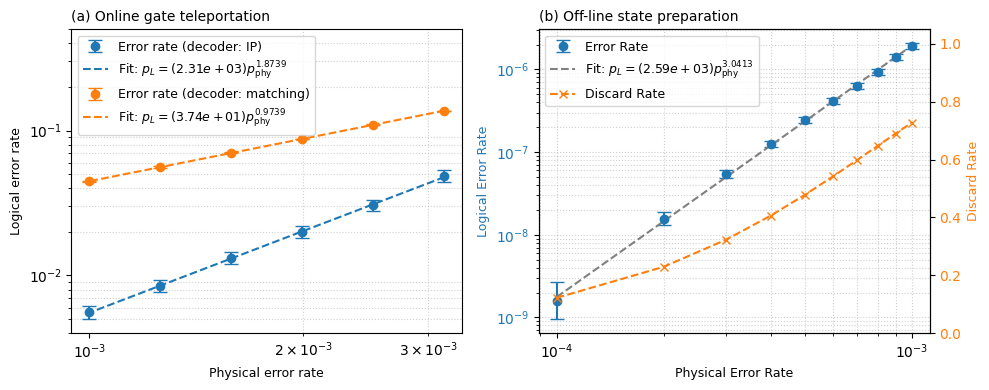

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# 3. 开始绘图
fig, ax = plt.subplots(1,2,figsize=(10, 4))

title_font_size = 10
label_font_size = 9

ax[0].set_title('(a) Online gate teleportation', loc='left', fontsize=title_font_size)
ax[0].set_xlabel('Physical error rate', fontsize=label_font_size)
ax[0].set_ylabel('Logical error rate', fontsize=label_font_size)
ax[0].set_yscale('log')
ax[0].set_ylim(0.004, 0.5)
ax[0].set_xscale('log')
ax[0].grid(True, which='minor', linestyle=':', alpha=0.6)

err_logical_before, err_logical_lows_before, err_logical_highs_before = get_plot_list(err_log_cnt_before, total_cnt_before)

handles = []
color_list = ['tab:blue', 'tab:orange']

for i, err_log_cnt in enumerate(err_log_cnt_after):
    err_logical, err_logical_lows, err_logical_highs = get_plot_list(err_log_cnt, total_cnt_after[i])
    delta_err_logical, delta_err_lows, delta_err_highs = get_delta_list(
        err_logical, err_logical_lows, err_logical_highs,
        err_logical_before, err_logical_lows_before, err_logical_highs_before
    )

    expo, coef = fit_error(delta_err_logical, err_phy)

    # 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
    asymmetric_err = [delta_err_lows, delta_err_highs]

    line1 = ax[0].errorbar(err_phy, delta_err_logical, yerr=asymmetric_err, fmt='o', color=color_list[i], capsize=5, label=f'Error rate (decoder: {"IP" if i==0 else "matching"})')
    line2, = ax[0].plot(err_phy, [coef * x**expo for x in err_phy], '--', color=color_list[i], label=fr'Fit: $p_L=({coef:.2e})p_{{\mathrm{{phy}}}}^{{{expo:.4f}}}$')
    handles.extend([line1, line2])

ax[0].legend(handles=handles, loc='upper left', fontsize=label_font_size)

# Plot the off-line protocol
color_err = 'tab:blue'
ax[1].set_title('(b) Off-line state preparation', loc='left', fontsize=title_font_size)
ax[1].set_xlabel('Physical Error Rate', fontsize=label_font_size)
ax[1].set_ylabel('Logical Error Rate', color=color_err, fontsize=label_font_size)
ax[1].set_yscale('log')
ax[1].set_xscale('log')

print(y_vals_ps, y_disc_rates_ps)

expo, coef = fit_error(y_vals_ps, sorted_xs)

line1 = ax[1].errorbar(sorted_xs, y_vals_ps, yerr=asymmetric_err_ps, 
                     color=color_err, fmt='o', capsize=5, label='Error Rate')
line2, = ax[1].plot(sorted_xs, [coef * x**expo for x in sorted_xs], '--', color='gray', label=fr'Fit: $p_L=({coef:.2e})p_{{\mathrm{{phy}}}}^{{{expo:.4f}}}$')

ax[1].tick_params(axis='y', labelcolor=color_err)
ax[1].grid(True, which='major', linestyle=':', alpha=0.6)

# --- 右轴：Discard Rate ---
ax2 = ax[1].twinx()
color_disc = 'tab:orange'
ax2.set_ylabel('Discard Rate', color=color_disc, fontsize=label_font_size)

line3, = ax2.plot(sorted_xs, y_disc_rates_ps, color=color_disc, 
                  marker='x', linestyle='--', label='Discard Rate')

ax2.tick_params(axis='y', labelcolor=color_disc)
ax2.set_ylim(0, 1.05) 

ax[1].grid(True, which='minor', linestyle=':', alpha=0.6)
# 图例
ax[1].legend(handles=[line1, line2, line3], loc='upper left', fontsize=label_font_size)

plt.tight_layout()
plt.savefig('error_rates.pdf', 
           bbox_inches='tight',  # 紧贴内容边界
           pad_inches=0) 

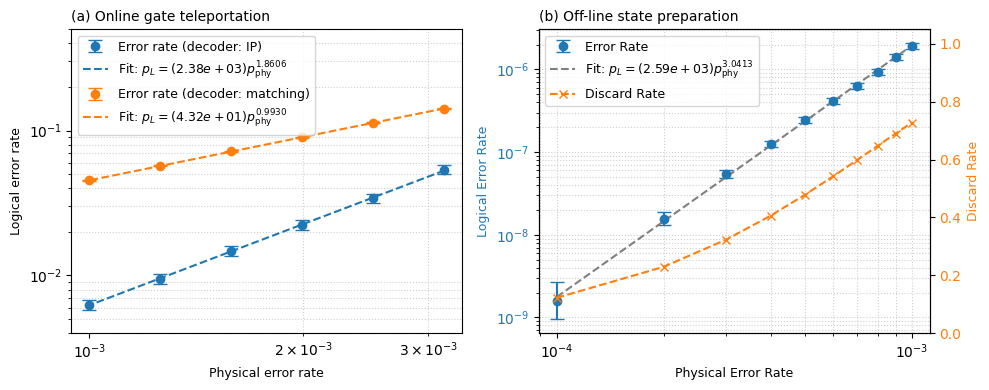

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# 3. 开始绘图
fig, ax = plt.subplots(1,2,figsize=(10, 4))

title_font_size = 10
label_font_size = 9

ax[0].set_title('(a) Online gate teleportation', loc='left', fontsize=title_font_size)
ax[0].set_xlabel('Physical error rate', fontsize=label_font_size)
ax[0].set_ylabel('Logical error rate', fontsize=label_font_size)
ax[0].set_yscale('log')
ax[0].set_ylim(0.004, 0.5)
ax[0].set_xscale('log')
ax[0].grid(True, which='minor', linestyle=':', alpha=0.6)

err_logical_before, err_logical_lows_before, err_logical_highs_before = get_plot_list(err_log_cnt_before, total_cnt_before)

handles = []
color_list = ['tab:blue', 'tab:orange']

for i, err_log_cnt in enumerate(err_log_cnt_after):
    err_logical, err_logical_lows, err_logical_highs = get_plot_list(err_log_cnt, total_cnt_after[i])
    delta_err_logical, delta_err_lows, delta_err_highs = err_logical, err_logical_lows, err_logical_highs
    # delta_err_logical, delta_err_lows, delta_err_highs = get_delta_list(
    #     err_logical, err_logical_lows, err_logical_highs,
    #     err_logical_before, err_logical_lows_before, err_logical_highs_before
    # )

    expo, coef = fit_error(delta_err_logical, err_phy)

    # 组合不对称的 Error Bar 数据: shape 为 (2, N) -> [row_lower, row_upper]
    asymmetric_err = [delta_err_lows, delta_err_highs]

    line1 = ax[0].errorbar(err_phy, delta_err_logical, yerr=asymmetric_err, fmt='o', color=color_list[i], capsize=5, label=f'Error rate (decoder: {"IP" if i==0 else "matching"})')
    line2, = ax[0].plot(err_phy, [coef * x**expo for x in err_phy], '--', color=color_list[i], label=fr'Fit: $p_L=({coef:.2e})p_{{\mathrm{{phy}}}}^{{{expo:.4f}}}$')
    handles.extend([line1, line2])

ax[0].legend(handles=handles, loc='upper left', fontsize=label_font_size)

# Plot the off-line protocol
color_err = 'tab:blue'
ax[1].set_title('(b) Off-line state preparation', loc='left', fontsize=title_font_size)
ax[1].set_xlabel('Physical Error Rate', fontsize=label_font_size)
ax[1].set_ylabel('Logical Error Rate', color=color_err, fontsize=label_font_size)
ax[1].set_yscale('log')
ax[1].set_xscale('log')

expo, coef = fit_error(y_vals_ps, sorted_xs)

line1 = ax[1].errorbar(sorted_xs, y_vals_ps, yerr=asymmetric_err_ps, 
                     color=color_err, fmt='o', capsize=5, label='Error Rate')
line2, = ax[1].plot(sorted_xs, [coef * x**expo for x in sorted_xs], '--', color='gray', label=fr'Fit: $p_L=({coef:.2e})p_{{\mathrm{{phy}}}}^{{{expo:.4f}}}$')

ax[1].tick_params(axis='y', labelcolor=color_err)
ax[1].grid(True, which='major', linestyle=':', alpha=0.6)

# --- 右轴：Discard Rate ---
ax2 = ax[1].twinx()
color_disc = 'tab:orange'
ax2.set_ylabel('Discard Rate', color=color_disc, fontsize=label_font_size)

line3, = ax2.plot(sorted_xs, y_disc_rates_ps, color=color_disc, 
                  marker='x', linestyle='--', label='Discard Rate')

ax2.tick_params(axis='y', labelcolor=color_disc)
ax2.set_ylim(0, 1.05) 

ax[1].grid(True, which='minor', linestyle=':', alpha=0.6)
# 图例
ax[1].legend(handles=[line1, line2, line3], loc='upper left', fontsize=label_font_size)

plt.tight_layout()
# plt.savefig('error_rates.pdf', 
        #    bbox_inches='tight',  # 紧贴内容边界
        #    pad_inches=0) 